In [ ]:
!pip install --upgrade dataset-tools

In [1]:
import dataset_tools as dtools
dtools.download(dataset='FoodSeg103')

Unpacking 'foodseg103.tar': 100%|██████████| 21366/21366 [00:23<00:00, 922.97file/s] 


'/root/dataset-ninja/foodseg103'

In [45]:
import os
import json
import base64
import zlib
import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def decode_bitmap_safe(bitmap_data):
    try:
        decoded = base64.b64decode(bitmap_data)

        decompressed = zlib.decompress(decoded)

        with Image.open(io.BytesIO(decompressed)) as img:
            return img.convert('L')
    except Exception as e:
        print(f"Bitmap decoding error: {e}")
        return None


class DataSet(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]


        meta_path = "/root/dataset-ninja/foodseg103/meta.json"
        with open(meta_path, 'r') as f:
            meta = json.load(f)


        self.class_mapping = {}
        for idx, cls in enumerate(meta['classes']):
            self.class_mapping[cls['title']] = idx + 1
        self.num_classes = len(self.class_mapping) + 1


    def decode_mask_from_json(self, json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)

        height = data['size']['height']
        width = data['size']['width']
        mask = np.zeros((height, width), dtype=np.uint8)

        for obj in data['objects']:
            if obj['geometryType'] != 'bitmap':
                continue

            class_title = obj['classTitle']
            if class_title not in self.class_mapping:

                continue

            class_id = self.class_mapping[class_title]
            bitmap = obj['bitmap']
            origin_x, origin_y = bitmap['origin']

            bmp_img = decode_bitmap_safe(bitmap['data'])
            if bmp_img is None:
                print(f"Failed to decode bitmap for {class_title}")
                continue

            bmp_arr = np.array(bmp_img)
            h, w = bmp_arr.shape


            y_start = max(0, origin_y)
            y_end = min(height, origin_y + h)
            x_start = max(0, origin_x)
            x_end = min(width, origin_x + w)


            bmp_h = y_end - y_start
            bmp_w = x_end - x_start

            if bmp_h <= 0 or bmp_w <= 0:
                continue


            bmp_y_start = max(0, -origin_y)
            bmp_y_end = bmp_y_start + bmp_h
            bmp_x_start = max(0, -origin_x)
            bmp_x_end = bmp_x_start + bmp_w

            bmp_crop = bmp_arr[bmp_y_start:bmp_y_end, bmp_x_start:bmp_x_end]


            mask_region = mask[y_start:y_end, x_start:x_end]
            object_pixels = (bmp_crop > 128)
            mask_region[object_pixels] = class_id

        return Image.fromarray(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, img_filename + ".json")

        image = Image.open(img_path).convert("RGB")
        mask = self.decode_mask_from_json(mask_path)


        if self.transform:
            image = self.transform(image)


        mask = mask.resize((256, 256), resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):

        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)


        x = self.dconv_down4(x)


        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out


def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, masks in tqdm(dataloader, desc="Training"):
        images, masks = images.to(device), masks.to(device)


        outputs = model(images)
        loss = criterion(outputs, masks)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(dataloader)



base_dir = "/root/dataset-ninja/foodseg103"
image_dir = os.path.join(base_dir, "train/img")
mask_dir = os.path.join(base_dir, "train/ann")
meta_path = "/root/dataset-ninja/foodseg103/meta.json"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

full_dataset = DataSet(image_dir, mask_dir, transform=transform)
n_classes = full_dataset.num_classes


val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

model = UNet(n_classes=n_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
for epoch in range(10):
    print(f"\nEpoch {epoch+1}/10")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_foodseg103_best.pth")
        print("Saved best model")


torch.save(model.state_dict(), "unet_foodseg103_final.pth")
print("Training complete")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Epoch 1/10


Validation: 100%|██████████| 498/498 [00:26<00:00, 18.89it/s]


Train Loss: 2.6190, Val Loss: 2.1257
Saved best model

Epoch 2/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.20it/s]


Train Loss: 2.0850, Val Loss: 1.9761
Saved best model

Epoch 3/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.41it/s]


Train Loss: 1.9754, Val Loss: 1.8996
Saved best model

Epoch 4/10


Validation: 100%|██████████| 498/498 [00:26<00:00, 18.75it/s]


Train Loss: 1.9036, Val Loss: 1.8233
Saved best model

Epoch 5/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.29it/s]


Train Loss: 1.8542, Val Loss: 1.7836
Saved best model

Epoch 6/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.19it/s]


Train Loss: 1.8068, Val Loss: 1.7572
Saved best model

Epoch 7/10


Validation: 100%|██████████| 498/498 [00:26<00:00, 19.00it/s]


Train Loss: 1.7717, Val Loss: 1.7076
Saved best model

Epoch 8/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.43it/s]


Train Loss: 1.7286, Val Loss: 1.6951
Saved best model

Epoch 9/10


Validation: 100%|██████████| 498/498 [00:26<00:00, 19.10it/s]


Train Loss: 1.6894, Val Loss: 1.6379
Saved best model

Epoch 10/10


Validation: 100%|██████████| 498/498 [00:25<00:00, 19.25it/s]


Train Loss: 1.6562, Val Loss: 1.6111
Saved best model
Training complete


In [42]:
torch.cuda.empty_cache()

In [46]:
import matplotlib.pyplot as plt
import torchvision

def visualize_predictions(model, dataloader, device, num_samples=4):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    return

                img = images[i].cpu().permute(1, 2, 0).numpy()
                gt = masks[i].cpu().numpy()
                pred = preds[i].numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Image")
                axs[1].imshow(gt)
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred)
                axs[2].set_title("Prediction")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                images_shown += 1

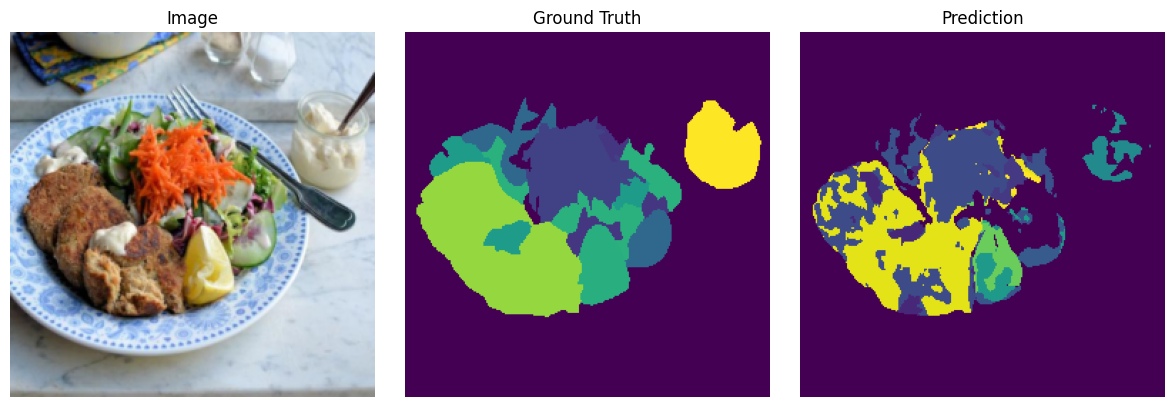

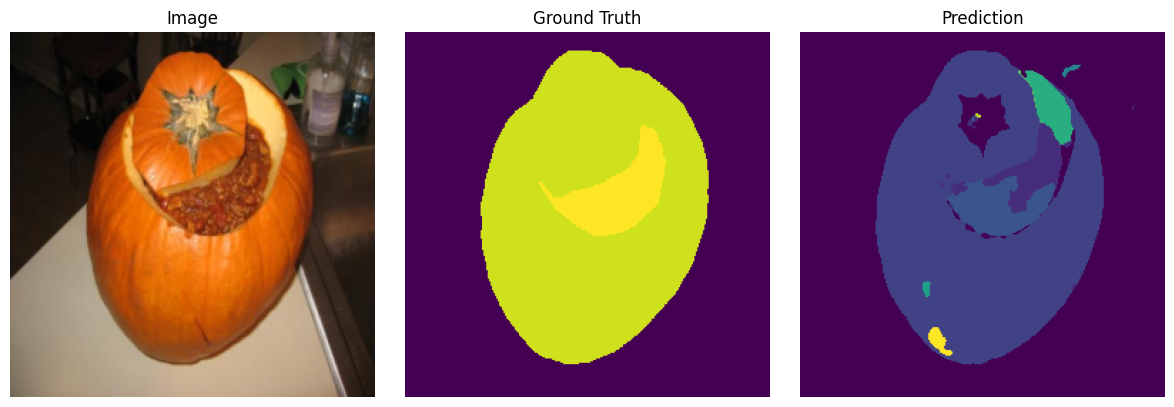

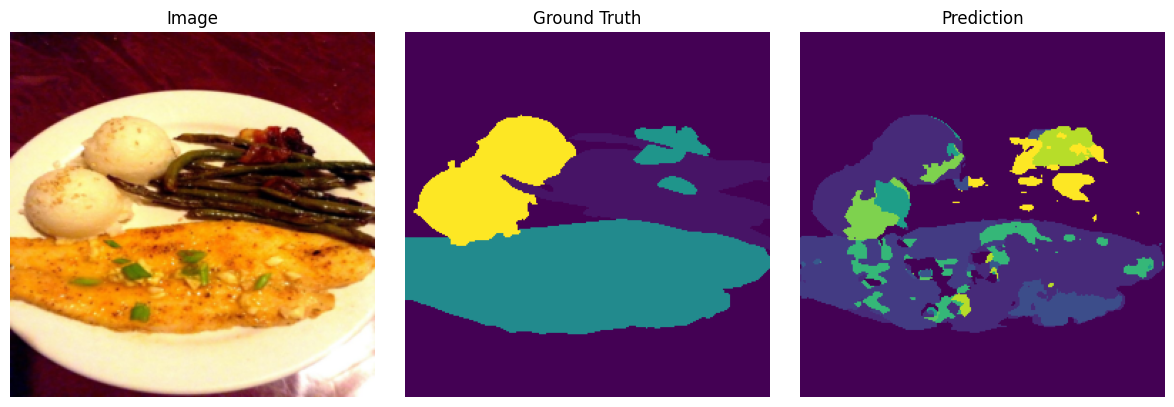

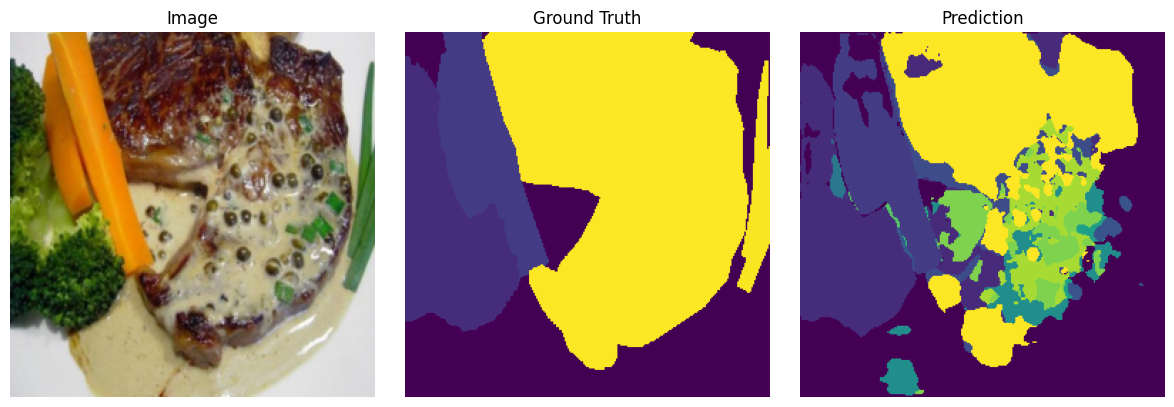

In [47]:
image_dir = "/root/dataset-ninja/foodseg103/test/img"
mask_dir = "/root/dataset-ninja/foodseg103/test/ann"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_dataset = DataSet(image_dir, mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

model.eval()

visualize_predictions(model=model, dataloader=test_loader, device=device)